# COCO Image Viewer
A single image COCO dataset viewer. Import COCO Instances JSON and view segmentations on top of that image.

In [1]:
import json
from pathlib import Path
from PIL import Image as PILImage
import IPython
import numpy as np
from math import trunc
import base64
from io import BytesIO

# CocoDataset Class
This class imports and processes an annotations JSON file that you will specify when creating an instance of the class.

In [14]:
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        
        # Customize these segmentation colors if you like, if there are more segmentations
        # than colors in an image, the remaining segmentations will default to white
        self.colors = ["aliceblue","antiquewhite","aqua","aquamarine","azure","beige","bisque","black","blanchedalmond","blue","blueviolet","brown","burlywood","cadetblue","chartreuse","chocolate","coral","cornflowerblue","cornsilk","crimson","cyan","darkblue","darkcyan","darkgoldenrod","darkgray","darkgrey","darkgreen","darkkhaki","darkmagenta","darkolivegreen","darkorange","darkorchid","darkred","darksalmon","darkseagreen","darkslateblue","darkslategray","darkslategrey","darkturquoise","darkviolet","deeppink","deepskyblue","dimgray","dimgrey","dodgerblue","firebrick","floralwhite","forestgreen","fuchsia","gainsboro","ghostwhite","gold","goldenrod","gray","grey","green","greenyellow","honeydew","hotpink","indianred","indigo","ivory","khaki","lavender","lavenderblush","lawngreen","lemonchiffon","lightblue","lightcoral","lightcyan","lightgoldenrodyellow","lightgray","lightgrey","lightgreen","lightpink","lightsalmon","lightseagreen","lightskyblue","lightslategray","lightslategrey","lightsteelblue","lightyellow","lime","limegreen","linen","magenta","maroon","mediumaquamarine","mediumblue","mediumorchid","mediumpurple","mediumseagreen","mediumslateblue","mediumspringgreen","mediumturquoise","mediumvioletred","midnightblue","mintcream","mistyrose","moccasin","navajowhite","navy","oldlace","olive","olivedrab","orange","orangered","orchid","palegoldenrod","palegreen","paleturquoise"] #['red', 'green', 'blue', 'yellow']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self._process_info()
        self._process_categories()
        self._process_images()
        self._process_segmentations()
    
    def _process_info(self):
        self.info = self.coco['info']
        
    def _process_categories(self):
        self.categories = dict()
        self.super_categories = dict()        
        self.categories = self.coco['categories']
           
    def _process_images(self):
        self.images = dict()
        for image in self.coco['images']:
            image_id = image['id']
            if image_id not in self.images:
                self.images[image_id] = image
            else:
                print(f'ERROR: Skipping duplicate image id: {image}')
                
    def _process_segmentations(self):
        self.segmentations = dict()
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)
        
    def display_info(self):
        print('Dataset Info')
        print('==================')
        for key, item in self.info.items():
            print(f'  {key}: {item}')
            
                
    def display_categories(self):
        print('Categories')
        print('==================')
        for cat_id in self.categories:
            print(f'    id {cat_id}: {cat_id["name"]}')
                
            print('')
            
    def display_image(self, image_id, show_bbox=True, show_polys=True, show_crowds=True):
        print('Image')
        print('==================')
        
        # Print image info
        image = self.images[image_id]
        for key, val in image.items():
            print(f'  {key}: {val}')
            
        # Open the image
        image_path = Path(self.image_dir) / image['file_name']
        image = PILImage.open(image_path)
        
        buffer = BytesIO()
        image.save(buffer, format='PNG')
        buffer.seek(0)
        
        data_uri = base64.b64encode(buffer.read()).decode('ascii')
        image_path = "data:image/png;base64,{0}".format(data_uri)
        
        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create bounding boxes and polygons
        bboxes = dict()
        polygons = dict()
        rle_regions = dict()
        seg_colors = dict()
        
        for i, seg in enumerate(self.segmentations[image_id]):
            seg_colors[seg['id']] = self.colors[i]
          
            print(f'  {seg_colors[seg["id"]]}: {self.categories[seg["category_id"]]["name"]}')
            
            bboxes[seg['id']] = np.multiply(seg['bbox'], adjusted_ratio).astype(int)
            
            if seg['iscrowd'] == 0:
                polygons[seg['id']] = []
                for seg_points in seg['segmentation']:
                    seg_points = np.multiply(seg_points, adjusted_ratio).astype(int)
                    polygons[seg['id']].append(str(seg_points).lstrip('[').rstrip(']'))
            else:
                # Decode the RLE
                px = 0
                rle_list = []
                for j, counts in enumerate(seg['segmentation']['counts']):
                    if counts < 0:
                        print(f'ERROR: One of the counts was negative, treating as 0: {counts}')
                        counts = 0
                    
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Create one or more vertical rectangles
                        x1 = trunc(px / image_height)
                        y1 = px % image_height
                        px += counts
                        x2 = trunc(px / image_height)
                        y2 = px % image_height
                        
                        if x2 == x1: # One vertical column
                            line = [x1, y1, 1, (y2 - y1)]
                            line = np.multiply(line, adjusted_ratio)
                            rle_list.append(line)
                        else: # Two or more columns
                            # Insert left-most line first
                            left_line = [x1, y1, 1, (image_height - y1)]
                            left_line = np.multiply(left_line, adjusted_ratio)
                            rle_list.append(left_line)
                            
                            # Insert middle lines (if needed)
                            lines_spanned = x2 - x1 + 1
                            if lines_spanned > 2: # Two columns won't have a middle
                                middle_lines = [(x1 + 1), 0, lines_spanned - 2, image_height]
                                middle_lines = np.multiply(middle_lines, adjusted_ratio)
                                rle_list.append(middle_lines)
                                
                            # Insert right-most line
                            right_line = [x2, 0, 1, y2]
                            right_line = np.multiply(right_line, adjusted_ratio)
                            rle_list.append(right_line)
                            
                if len(rle_list) > 0:
                    rle_regions[seg['id']] = rle_list
                                
                            
        
        # Draw the image
        html = '<div class="container" style="position:relative;">'
        html += f'<img src="{str(image_path)}" style="position:relative; top:0px; left:0px; width:{adjusted_width}px;">'
        html += '<div class="svgclass">'
        html += f'<svg width="{adjusted_width}" height="{adjusted_height}">'
        
        # Draw shapes on image
        if show_polys:
            for seg_id, points_list in polygons.items():
                for points in points_list:
                    html += f'<polygon points="{points}" \
                        style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; fill-opacity:0.5; stroke-width:1;" />'
        
        if show_crowds:
            for seg_id, line_list in rle_regions.items():
                for line in line_list:
                    html += f'<rect x="{line[0]}" y="{line[1]}" width="{line[2]}" height="{line[3]}" \
                        style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; \
                        fill-opacity:0.5; stroke-opacity:0.5" />'
        
        if show_bbox:
            for seg_id, bbox in bboxes.items():
                html += f'<rect x="{bbox[0]}" y="{bbox[1]}" width="{bbox[2]}" height="{bbox[3]}" \
                    style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; fill-opacity:0" />'
        
        html += '</svg>'
        html += '</div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass {position: absolute; top:0px; left: 0px}'
        html += '</style>'
        
        return html
        
        

In [17]:
instances_json_path = "/home/grubio/unity3d/UnityTechnologies/SynthDet/0a94bf7a-2184-47d8-bdd0-1ddb3d52ee0f/coco_instances.json"
images_path = "/home/grubio/unity3d/UnityTechnologies/SynthDet/0a94bf7a-2184-47d8-bdd0-1ddb3d52ee0f/RGB0d1cf8d8-2b40-487b-9b05-d47074886728"
coco_dataset = CocoDataset(instances_json_path, images_path)
# coco_dataset.display_info()
# coco_dataset.display_categories()

Image
  file_name: rgb_50.png
  width: 1920
  height: 1080
  id: 2
  aliceblue: utensil_candle_decorators
  antiquewhite: snack_cookie_petitecolier
  aqua: snack_coffeecakes_hostess
  aquamarine: snack_coffeecakes_hostess
  azure: toiletry_toothpaste_colgate
  beige: utensil_coffee_filters
  bisque: candy_minipralines_lindt
  black: drink_adrenaline_shock
  blanchedalmond: cracker_triscuit_avocado
  blue: storage_ziploc_sandwich
  blueviolet: snack_coffeecakes_hostess
  brown: drink_adrenaline_shock
  burlywood: cracker_triscuit_avocado
  cadetblue: utensil_cottonovals_signaturecare
  chartreuse: utensil_papertowels_valuecorner
  chocolate: soup_tomato_pacific
  coral: candy_raffaello_confetteria
  cornflowerblue: drink_greentea_itoen
  cornsilk: heineken
  crimson: cereal_raisin_bran
  cyan: candy_minipralines_lindt
  darkblue: drink_orangejuice_minutemaid
  darkcyan: cereal_cheerios_honeynut
  darkgoldenrod: snack_cookie_petitecolier
  darkgray: cereal_raisin_bran
  darkgrey: chips_s


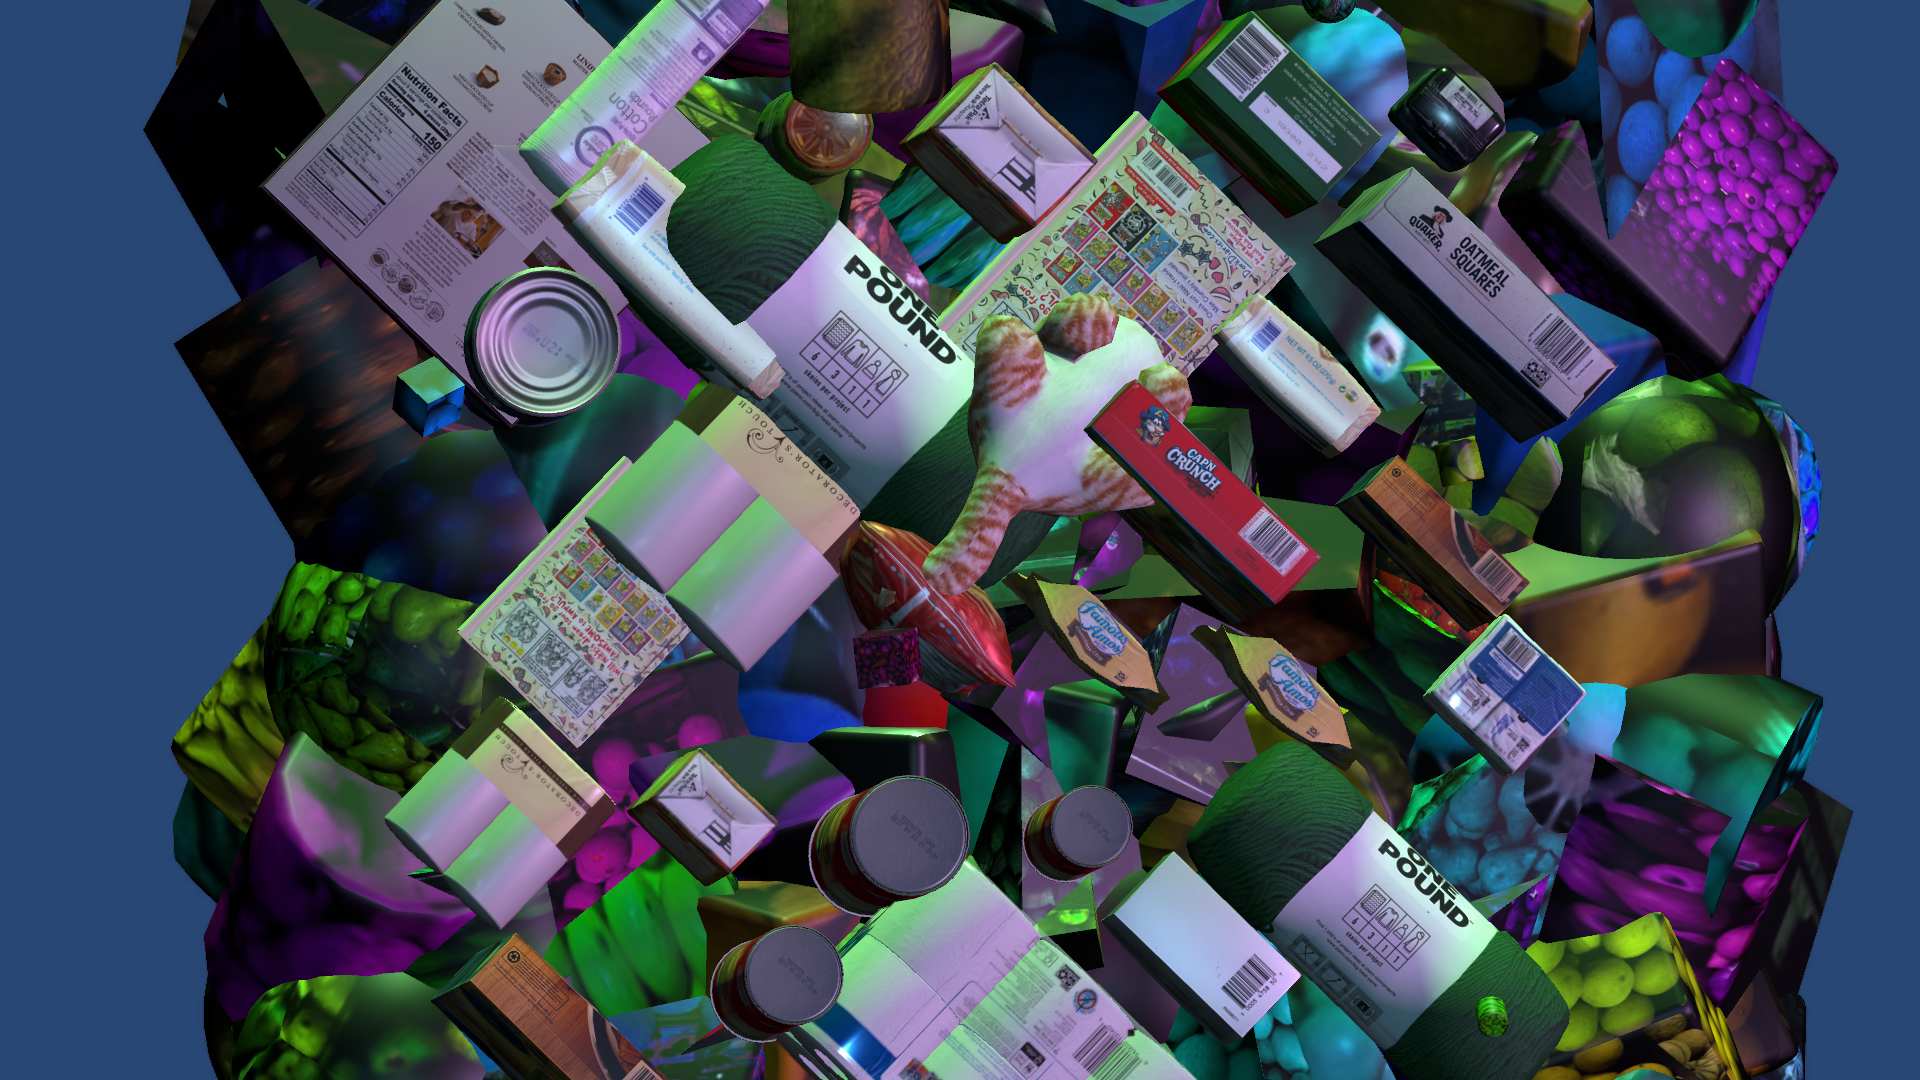

In [18]:
html = coco_dataset.display_image(2)
IPython.display.HTML(html)